# Advanced Analytics Functions

*  multidimensional aggregations: Calculating subtotals and totals across a set of grouping
columns is commonly needed. 
* performing aggregations based on time windows, which is useful when working with time-series
*  perform aggregations within a logical grouping of rows, referred to as a window. 

In [1]:
from pyspark.sql import SparkSession
import os
import pyspark.sql.functions as F

spark = SparkSession.builder.appName("SQL").getOrCreate()

24/05/24 17:19:40 WARN Utils: Your hostname, msi-MAG resolves to a loopback address: 127.0.1.1; using 192.168.0.129 instead (on interface wlp3s0)
24/05/24 17:19:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/24 17:19:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
path = "/home/msi/beginning-apache-spark-3/chapter4/data/flights"
path = os.path.join(path,"flight-summary.csv")
path

'/home/msi/beginning-apache-spark-3/chapter4/data/flights/flight-summary.csv'

In [4]:
flight_summary =  spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema","true")\
    .load(path)

flight_summary.show(10, False)

+-----------+------------------------------------------------+------------+------------+---------+--------------------------------------------+----------------+----------+-----+
|origin_code|origin_airport                                  |origin_city |origin_state|dest_code|dest_airport                                |dest_city       |dest_state|count|
+-----------+------------------------------------------------+------------+------------+---------+--------------------------------------------+----------------+----------+-----+
|BQN        |Rafael Hernández Airport                        |Aguadilla   |PR          |MCO      |Orlando International Airport               |Orlando         |FL        |441  |
|PHL        |Philadelphia International Airport              |Philadelphia|PA          |MCO      |Orlando International Airport               |Orlando         |FL        |4869 |
|MCI        |Kansas City International Airport               |Kansas City |MO          |IAH      |George Bush 

Filter data

In [5]:
twoStatesSummary = flight_summary\
    .select("origin_state","origin_city","count")\
    .where((F.col("origin_state") == "CA" ) | (F.col("origin_state") == "NY"))\
    .where((F.col("count") > 1) & (F.col("count") < 20))\
    .where(F.col("origin_city") != "White Plains")\
    .where(F.col("origin_city") != "Newburgh")\
    .where(F.col("origin_city") != "Mammoth Lakes")\
    .where(F.col("origin_city") != "Ontario")

In [7]:
print(twoStatesSummary.printSchema())
twoStatesSummary.show()

root
 |-- origin_state: string (nullable = true)
 |-- origin_city: string (nullable = true)
 |-- count: integer (nullable = true)

None
+------------+-------------+-----+
|origin_state|  origin_city|count|
+------------+-------------+-----+
|          NY|     New York|    4|
|          NY|       Elmira|   15|
|          CA|    San Diego|   18|
|          CA|San Francisco|   14|
|          NY|     New York|    2|
|          NY|       Albany|    5|
|          CA|San Francisco|    2|
|          NY|       Albany|    3|
|          NY|       Albany|    9|
|          NY|     New York|    4|
|          CA|San Francisco|    5|
|          CA|    San Diego|    4|
|          NY|     New York|   10|
+------------+-------------+-----+



ROLL UP extends GROUP BY
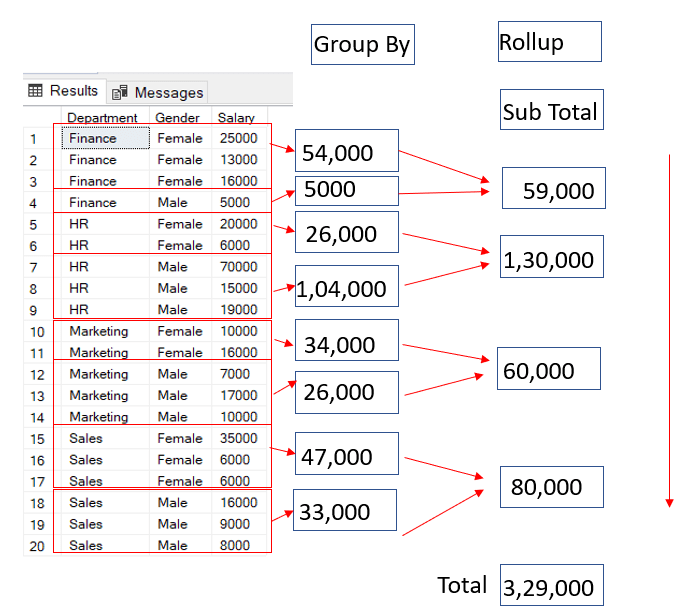

## RollUp
apply group by + the intermediary aggregations (subtotals displayed in NULL row)

In [12]:
twoStatesSummary.rollup("origin_state", "origin_city").agg(F.sum("count").alias("total"))\
.orderBy(F.col("origin_state").desc_nulls_last(),
         F.col("origin_city").desc_nulls_last()).show()

+------------+-------------+-----+
|origin_state|  origin_city|total|
+------------+-------------+-----+
|          NY|     New York|   20|
|          NY|       Elmira|   15|
|          NY|       Albany|   17|
|          NY|         null|   52|
|          CA|San Francisco|   21|
|          CA|    San Diego|   22|
|          CA|         null|   43|
|        null|         null|   95|
+------------+-------------+-----+



> **Look very well** <br>
> see those NULL columns? those are the agg of the above values. Ex: 
> * 20 + 15 + 17 = 52  

> This output shows the subtotals per state on the third and seventh lines. The last line
shows the total with a null value in both the original_state and origin_city columns.

## Cubes
A cube is a more advanced version of a rollup. It performs the aggregations across all
the combinations of the grouping columns. Therefore, the result includes what a rollup
provides, as well as other combinations.

In [13]:
# perform the cube across origin_state and origin_city
twoStatesSummary.cube("origin_state", "origin_city").agg(F.sum("count").alias("total"))\
.orderBy(F.col("origin_state").desc_nulls_last(),
         F.col("origin_city").desc_nulls_last()).show()

+------------+-------------+-----+
|origin_state|  origin_city|total|
+------------+-------------+-----+
|          NY|     New York|   20|
|          NY|       Elmira|   15|
|          NY|       Albany|   17|
|          NY|         null|   52|
|          CA|San Francisco|   21|
|          CA|    San Diego|   22|
|          CA|         null|   43|
|        null|San Francisco|   21|
|        null|    San Diego|   22|
|        null|     New York|   20|
|        null|       Elmira|   15|
|        null|       Albany|   17|
|        null|         null|   95|
+------------+-------------+-----+



the lines with a null value in the origin_state column represent an
aggregation of all the cities in a state.

# Aggregation with Time Windows

Window functions come in a few versions, but they all require a timestamp type
column and a window length, specified in seconds, minutes, hours, days, or weeks.

In [16]:
path = "/home/msi/beginning-apache-spark-3/chapter4/data/stocks"
path = os.path.join(path,"aapl-2017.csv")
path

'/home/msi/beginning-apache-spark-3/chapter4/data/stocks/aapl-2017.csv'

In [17]:
appleOneYearDF = spark.read.format("csv")\
.option("header", "true")\
.option("inferSchema","true")\
.load(path)

In [18]:
print(appleOneYearDF.printSchema())
appleOneYearDF.show(10)

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)

None
+----------+----------+----------+----------+----------+----------+--------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|
+----------+----------+----------+----------+----------+----------+--------+
|2017-01-03|115.800003|116.330002|114.760002|116.150002| 114.31176|28781900|
|2017-01-04|115.849998|116.510002|    115.75|116.019997|114.183815|21118100|
|2017-01-05|115.919998|116.860001|115.809998|116.610001|114.764473|22193600|
|2017-01-06|116.779999|118.160004|116.470001|117.910004|116.043915|31751900|
|2017-01-09|117.949997|    119.43|117.940002|118.989998|117.106812|33561900|
|2017-01-10|118.769997|119.379997|118.300003|119.110001|117.224907|24462100|
|2017-01-11|118.739998|    119.93|118.

Fix Window

In [21]:
# calculate the weekly average price using window function inside the groupBy transformation
# this is an example of the tumbling window, aka fixed window
appleWeeklyAvgDF = appleOneYearDF.\
    groupBy(F.window("Date", "1 week")).\
    agg(F.avg("Close").alias("weekly_avg"))
appleWeeklyAvgDF.show(10, truncate=False)

+------------------------------------------+------------------+
|window                                    |weekly_avg        |
+------------------------------------------+------------------+
|{2017-03-16 01:00:00, 2017-03-23 01:00:00}|140.7260008       |
|{2017-10-19 02:00:00, 2017-10-26 02:00:00}|156.66800239999998|
|{2017-09-07 02:00:00, 2017-09-14 02:00:00}|159.7839998       |
|{2017-01-12 01:00:00, 2017-01-19 01:00:00}|119.70249950000002|
|{2017-12-21 01:00:00, 2017-12-28 01:00:00}|171.81500250000002|
|{2017-04-20 02:00:00, 2017-04-27 02:00:00}|143.58199759999997|
|{2017-07-27 02:00:00, 2017-08-03 02:00:00}|152.19800100000003|
|{2017-08-03 02:00:00, 2017-08-10 02:00:00}|158.3320008       |
|{2017-08-17 02:00:00, 2017-08-24 02:00:00}|158.7480012       |
|{2017-04-06 02:00:00, 2017-04-13 02:00:00}|142.19800100000003|
+------------------------------------------+------------------+
only showing top 10 rows



look in the schema the window col

In [23]:
appleWeeklyAvgDF.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- weekly_avg: double (nullable = true)



order by

In [24]:
# display the result with ordering by start time and
# round up to 2 decimal points
appleWeeklyAvgDF.orderBy("window.start")\
    .selectExpr("window.start","window.end",
                "round(weekly_avg, 2) as weekly_avg").show(5)

+-------------------+-------------------+----------+
|              start|                end|weekly_avg|
+-------------------+-------------------+----------+
|2016-12-29 01:00:00|2017-01-05 01:00:00|    116.26|
|2017-01-05 01:00:00|2017-01-12 01:00:00|     119.0|
|2017-01-12 01:00:00|2017-01-19 01:00:00|     119.7|
|2017-01-19 01:00:00|2017-01-26 01:00:00|    120.77|
|2017-01-26 01:00:00|2017-02-02 01:00:00|    124.44|
+-------------------+-------------------+----------+
only showing top 5 rows



> Use the Time Window Function to Calculate the Monthly Average
Closing Price of Apple Stock
> * look at the 2 subleves, 4 weeks window length and slide by one week each time

* **Slide Duration ("1 week"):** This specifies how often a new window starts. Here, a new window starts every 1 week (7 days). <br>

| Window  | Duration         |
|---------|------------------|
| Window 1| [Jan 1 - Jan 28] |
| Window 2| [Jan 8 - Feb 4]  |
| Window 3| [Jan 15 - Feb 11]|
| Window 4| [Jan 22 - Feb 18]|
| ...     | ...              |


In [27]:
appleMonthlyAvgDF = appleOneYearDF.\
    groupBy(F.window("Date", "4 week", "1 week")).\
    agg(F.avg("Close").alias("monthly_avg"))

print(appleMonthlyAvgDF.printSchema())
appleMonthlyAvgDF.show(10, truncate=False)

root
 |-- window: struct (nullable = true)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- monthly_avg: double (nullable = true)

None
+------------------------------------------+------------------+
|window                                    |monthly_avg       |
+------------------------------------------+------------------+
|{2017-06-01 02:00:00, 2017-06-29 02:00:00}|147.7544983       |
|{2017-01-19 01:00:00, 2017-02-16 01:00:00}|127.63649855000001|
|{2017-03-02 01:00:00, 2017-03-30 02:00:00}|140.59000005000001|
|{2017-06-29 02:00:00, 2017-07-27 02:00:00}|147.98842094736844|
|{2016-12-15 01:00:00, 2017-01-12 01:00:00}|117.97375037500001|
|{2017-02-09 01:00:00, 2017-03-09 01:00:00}|136.99999921052634|
|{2017-10-26 02:00:00, 2017-11-23 01:00:00}|171.3621054736842 |
|{2017-02-16 01:00:00, 2017-03-16 01:00:00}|138.43105273684213|
|{2017-07-13 02:00:00, 2017-08-10 02:00:00}|153.0905006       |
|{2017-06-22 02:00:00, 2017-07-20 02:00:00}|146.2105

In [28]:
appleMonthlyAvgDF.orderBy("window.start")\
    .selectExpr("window.start","window.end",
                "round(monthly_avg, 2) as monthly_avg").show(5)

+-------------------+-------------------+-----------+
|              start|                end|monthly_avg|
+-------------------+-------------------+-----------+
|2016-12-08 01:00:00|2017-01-05 01:00:00|     116.26|
|2016-12-15 01:00:00|2017-01-12 01:00:00|     117.97|
|2016-12-22 01:00:00|2017-01-19 01:00:00|     118.55|
|2016-12-29 01:00:00|2017-01-26 01:00:00|      119.2|
|2017-01-05 01:00:00|2017-02-02 01:00:00|     121.05|
+-------------------+-------------------+-----------+
only showing top 5 rows



> Since the sliding window interval is one week, 
the start time difference between two consecutive rows is one week apart. 

# Window Functions

### Ranking Functions

| Name         | Description                                                                                                    |
|--------------|----------------------------------------------------------------------------------------------------------------|
| rank         | Returns the rank or order of rows within a frame based on some sorting order.                                   |
| dense_rank   | Similar to rank, but leaves no gaps in the ranks when there are ties.                                           |
| percen_rank  | Returns the relative rank of rows within a frame.                                                              |
| ntile(n)     | Returns the ntile group ID in an ordered window partition. For example, if n is 4, the first quarter of the rows get a value of 1, the second quarter of rows get a value of 2, and so on. |
| row_number   | Returns a sequential number starting with 1 within a frame.                                                      |


### Analytic Functions

| Name           | Description                                                                                                                     |
|----------------|---------------------------------------------------------------------------------------------------------------------------------|
| cume_dist      | Returns the cumulative distribution of values within a frame. In other words, it calculates the fraction of rows that are below the current row. |
| lag(col, offset) | Returns the value of the column that is offset rows before the current row.                                                   |
| lead(col, offset) | Returns the value of the column that is offset rows after the current row.                                                     |


In [30]:
txDataDF = spark.createDataFrame([("John", "2017-07-02", 13.35),
("John", "2017-07-06", 27.33),
("John", "2017-07-04", 21.72),
("Mary", "2017-07-07", 69.74),
("Mary", "2017-07-01", 59.44),
("Mary", "2017-07-05", 80.14)] ,["name", "tx_date", "amount"])

In [31]:
txDataDF.show()

+----+----------+------+
|name|   tx_date|amount|
+----+----------+------+
|John|2017-07-02| 13.35|
|John|2017-07-06| 27.33|
|John|2017-07-04| 21.72|
|Mary|2017-07-07| 69.74|
|Mary|2017-07-01| 59.44|
|Mary|2017-07-05| 80.14|
+----+----------+------+



In [35]:
from pyspark.sql.window import Window

partitionBy (defined on the windows before applying)

In [36]:
forRankingWindow = Window.partitionBy("name").orderBy(F.col("amount").desc())

In [38]:
txDataWithRankDF = txDataDF.withColumn("rank", F.rank().over(forRankingWindow))
txDataWithRankDF.show()

+----+----------+------+----+
|name|   tx_date|amount|rank|
+----+----------+------+----+
|John|2017-07-06| 27.33|   1|
|John|2017-07-04| 21.72|   2|
|John|2017-07-02| 13.35|   3|
|Mary|2017-07-05| 80.14|   1|
|Mary|2017-07-07| 69.74|   2|
|Mary|2017-07-01| 59.44|   3|
+----+----------+------+----+



> Applying the max Window Function to Find the Difference of Each
Row and the Highest Amount

In addition to partitioning
by the username, it needs to define a frame boundary that includes all the rows in
each partition. To do that, you use the `Window.rangeBetween` function with `Window.unboundedPreceding` as the start value and `Window.unboundedFollowing` as the end
value. 

In [46]:
# Step 1 - Operation Window
forEntireRangeWindow = Window.partitionBy("name").orderBy(
    F.col("amount").desc()).rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)


In [47]:
# Step 2 - Operation MAX (of the window) - this col
amount_difference = F.max("amount").over(forEntireRangeWindow) - F.col("amount")

In [49]:
# Step 3 - apply it to the logic
txDataDF.withColumn("amount_difference", F.round(amount_difference,3)).show()

+----+----------+------+-----------------+
|name|   tx_date|amount|amount_difference|
+----+----------+------+-----------------+
|John|2017-07-06| 27.33|              0.0|
|John|2017-07-04| 21.72|             5.61|
|John|2017-07-02| 13.35|            13.98|
|Mary|2017-07-05| 80.14|              0.0|
|Mary|2017-07-07| 69.74|             10.4|
|Mary|2017-07-01| 59.44|             20.7|
+----+----------+------+-----------------+



> Applying the Average Window Function to Compute the Moving
Average Transaction Amount

In [50]:
# Step 1 - define the window
forMovingAvgWindow = Window.partitionBy("name").orderBy("tx_date").rowsBetween(Window.currentRow-1,Window.currentRow+1)

In [51]:
# Step 2 - define the operation over the window
txMovingAvg = F.avg("amount").over(forMovingAvgWindow)

In [52]:
# Step 3 - apply it to the DF
txDataDF.withColumn("moving_avg", F.round(txMovingAvg,3)).show()


+----+----------+------+----------+
|name|   tx_date|amount|moving_avg|
+----+----------+------+----------+
|John|2017-07-02| 13.35|    17.535|
|John|2017-07-04| 21.72|      20.8|
|John|2017-07-06| 27.33|    24.525|
|Mary|2017-07-01| 59.44|     69.79|
|Mary|2017-07-05| 80.14|    69.773|
|Mary|2017-07-07| 69.74|     74.94|
+----+----------+------+----------+



First Row

In [53]:
(13.35 + 21.72) / 2 

17.535

second row

In [54]:
(13.35 + 21.72 + 27.33) / 3 

20.8

third row NEW WINDOW (Mary)

> Applying the sum Window Function to Compute the Cumulative
Sum of Transaction Amount

In [56]:
# Step 1 - define de window
forCumulativeSumWindow = Window.partitionBy("name").orderBy("tx_date")\
    .rowsBetween(Window.unboundedPreceding,Window.currentRow)

`Window.unboundedPreceding` represents an unbounded window boundary that goes all the way back to the beginning of the partition
* Unbounded Preceding: When used as the lower bound of a window frame, it means that the window frame starts from the first row of the partition.

In [57]:
# Step2 - define the operation
txCumulativeSum = F.sum("amount").over(forCumulativeSumWindow)

In [58]:
# Step3 - apply to DF
txDataDF.withColumn("CumulativeSum", F.round(txCumulativeSum,3)).show()


+----+----------+------+-------------+
|name|   tx_date|amount|CumulativeSum|
+----+----------+------+-------------+
|John|2017-07-02| 13.35|        13.35|
|John|2017-07-04| 21.72|        35.07|
|John|2017-07-06| 27.33|         62.4|
|Mary|2017-07-01| 59.44|        59.44|
|Mary|2017-07-05| 80.14|       139.58|
|Mary|2017-07-07| 69.74|       209.32|
+----+----------+------+-------------+



In [60]:
13.35

13.35

In [59]:
13.35 + 21.72

35.07

In [61]:
13.35 + 21.72 + 27.33

62.4

## Inside SQL

In [62]:
# register the txDataDF as a temporary view called tx_data
txDataDF.createOrReplaceTempView("tx_data")

In [66]:
# RANK window function to find top two highest transaction amount
spark.sql("""select name
                , tx_date
                , amount
                , RANK() OVER (PARTITION BY name ORDER BY amount DESC) as rank 
                from tx_data""").show()

+----+----------+------+----+
|name|   tx_date|amount|rank|
+----+----------+------+----+
|John|2017-07-06| 27.33|   1|
|John|2017-07-04| 21.72|   2|
|John|2017-07-02| 13.35|   3|
|Mary|2017-07-05| 80.14|   1|
|Mary|2017-07-07| 69.74|   2|
|Mary|2017-07-01| 59.44|   3|
+----+----------+------+----+



In [68]:
# difference between maximum transaction amount
spark.sql("""select name
          , tx_date, amount
          , round((max_amount - amount),2) as amount_diff  
          from
            (select name, tx_date, amount
            , MAX(amount) OVER (PARTITION BY name ORDER BY amount DESC 
            RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as max_amount 
            from tx_data)""").show()

+----+----------+------+-----------+
|name|   tx_date|amount|amount_diff|
+----+----------+------+-----------+
|John|2017-07-06| 27.33|        0.0|
|John|2017-07-04| 21.72|       5.61|
|John|2017-07-02| 13.35|      13.98|
|Mary|2017-07-05| 80.14|        0.0|
|Mary|2017-07-07| 69.74|       10.4|
|Mary|2017-07-01| 59.44|       20.7|
+----+----------+------+-----------+



In [69]:
# moving average
spark.sql("""select name, tx_date, amount, round(moving_avg,2) as moving_avg
from
(
select name, tx_date, amount, AVG(amount) OVER
(PARTITION BY name ORDER BY tx_date
ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING
) as moving_avg from tx_data)"""
).show()

+----+----------+------+----------+
|name|   tx_date|amount|moving_avg|
+----+----------+------+----------+
|John|2017-07-02| 13.35|     17.54|
|John|2017-07-04| 21.72|      20.8|
|John|2017-07-06| 27.33|     24.53|
|Mary|2017-07-01| 59.44|     69.79|
|Mary|2017-07-05| 80.14|     69.77|
|Mary|2017-07-07| 69.74|     74.94|
+----+----------+------+----------+



In [70]:
# cumulative sum
spark.sql("""select name, tx_date, amount, round(culm_sum,2) as moving_avg
from
(
select name, tx_date, amount, SUM(amount) OVER
(PARTITION BY name ORDER BY tx_date
ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
) as culm_sum from tx_data)"""
).show()

+----+----------+------+----------+
|name|   tx_date|amount|moving_avg|
+----+----------+------+----------+
|John|2017-07-02| 13.35|     13.35|
|John|2017-07-04| 21.72|     35.07|
|John|2017-07-06| 27.33|      62.4|
|Mary|2017-07-01| 59.44|     59.44|
|Mary|2017-07-05| 80.14|    139.58|
|Mary|2017-07-07| 69.74|    209.32|
+----+----------+------+----------+



# Explain
> in the output, you see four sections: 
> * parsed logical plan
> * analyzed logical plan optimized
> * logical plan
> * physical plan

Using the explain Function to Generate the Logical and Physical Plans

In [3]:
path = "/home/msi/beginning-apache-spark-3/chapter3/data/movies"
path = os.path.join(path,"movies.parquet")
path

'/home/msi/beginning-apache-spark-3/chapter3/data/movies/movies.parquet'

In [5]:
# read movies data in Parquet format
moviesDF = spark.read.load(path)
print(moviesDF.printSchema())
moviesDF.show(5)



root
 |-- actor_name: string (nullable = true)
 |-- movie_title: string (nullable = true)
 |-- produced_year: long (nullable = true)

None
+-----------------+------------------+-------------+
|       actor_name|       movie_title|produced_year|
+-----------------+------------------+-------------+
|McClure, Marc (I)|      Coach Carter|         2005|
|McClure, Marc (I)|       Superman II|         1980|
|McClure, Marc (I)|         Apollo 13|         1995|
|McClure, Marc (I)|          Superman|         1978|
|McClure, Marc (I)|Back to the Future|         1985|
+-----------------+------------------+-------------+
only showing top 5 rows



In [9]:
#  perform two filtering conditions
newMoviesDF = moviesDF.filter(F.col("produced_year") > 1970)\
                              .withColumn("produced_decade",
                                          F.substring(
                                              (F.col("produced_year") - F.col("produced_year") % 10)
                                              ,-2,2)
                                              )
newMoviesDF.show(5)

+-----------------+------------------+-------------+---------------+
|       actor_name|       movie_title|produced_year|produced_decade|
+-----------------+------------------+-------------+---------------+
|McClure, Marc (I)|      Coach Carter|         2005|             00|
|McClure, Marc (I)|       Superman II|         1980|             80|
|McClure, Marc (I)|         Apollo 13|         1995|             90|
|McClure, Marc (I)|          Superman|         1978|             70|
|McClure, Marc (I)|Back to the Future|         1985|             80|
+-----------------+------------------+-------------+---------------+
only showing top 5 rows

None


In [10]:
latestMoviesDF = newMoviesDF.select("movie_title", "produced_decade")\
    .where(F.col("produced_decade") > 2010)

In [11]:
# display both logical and physical plans
latestMoviesDF.explain(True)

== Parsed Logical Plan ==
'Filter ('produced_decade > 2010)
+- Project [movie_title#21, produced_decade#84]
   +- Project [actor_name#20, movie_title#21, produced_year#22L, substring(cast((produced_year#22L - (produced_year#22L % cast(10 as bigint))) as string), -2, 2) AS produced_decade#84]
      +- Filter (produced_year#22L > cast(1970 as bigint))
         +- Relation [actor_name#20,movie_title#21,produced_year#22L] parquet

== Analyzed Logical Plan ==
movie_title: string, produced_decade: string
Filter (cast(produced_decade#84 as int) > 2010)
+- Project [movie_title#21, produced_decade#84]
   +- Project [actor_name#20, movie_title#21, produced_year#22L, substring(cast((produced_year#22L - (produced_year#22L % cast(10 as bigint))) as string), -2, 2) AS produced_decade#84]
      +- Filter (produced_year#22L > cast(1970 as bigint))
         +- Relation [actor_name#20,movie_title#21,produced_year#22L] parquet

== Optimized Logical Plan ==
Project [movie_title#21, substring(cast((produce

>  form of a string to allow you to specify which of the five modes to see in the
output

| Mode      | Description                                                                             |
|-----------|-----------------------------------------------------------------------------------------|
| simple    | Print only a physical plan.                                                             |
| extended  | Print both logical and physical plans.                                                  |
| codegen   | Print a physical plan and the generated codes (if they are available).                  |
| cost      | Print a logical plan and statistics if they are available.                              |
| formatted | Split the explain output into two sections; a physical plan outline and details.        |


In [13]:
latestMoviesDF.explain("formatted")

== Physical Plan ==
* Project (4)
+- * Filter (3)
   +- * ColumnarToRow (2)
      +- Scan parquet  (1)


(1) Scan parquet 
Output [2]: [movie_title#21, produced_year#22L]
Batched: true
Location: InMemoryFileIndex [file:/home/msi/beginning-apache-spark-3/chapter3/data/movies/movies.parquet]
PushedFilters: [IsNotNull(produced_year), GreaterThan(produced_year,1970)]
ReadSchema: struct<movie_title:string,produced_year:bigint>

(2) ColumnarToRow [codegen id : 1]
Input [2]: [movie_title#21, produced_year#22L]

(3) Filter [codegen id : 1]
Input [2]: [movie_title#21, produced_year#22L]
Condition : ((isnotnull(produced_year#22L) AND (produced_year#22L > 1970)) AND (cast(substring(cast((produced_year#22L - (produced_year#22L % 10)) as string), -2, 2) as int) > 2010))

(4) Project [codegen id : 1]
Output [2]: [movie_title#21, substring(cast((produced_year#22L - (produced_year#22L % 10)) as string), -2, 2) AS produced_decade#84]
Input [2]: [movie_title#21, produced_year#22L]




In [14]:
spark.stop()